# SPDAvgPooling-4

This notebook contains training run for SPDAvgPooling model. 

If you are using Colab or Kaggle, clone the repository and add path (if needed).

In [1]:
# !git clone https://github.com/MarioAuditore/geomjax.git

In [2]:
# Add path if needed
# import sys
# sys.path.append("./")

In [3]:
import os
from typing import Any, Callable, Sequence
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8' # Use 4 CPU devices

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
import numpy as np
import scipy

import jax
from jax import jit, random, grad, jacobian
from jax import numpy as jnp
from jax.sharding import PositionalSharding

key = random.PRNGKey(1234)
jax.devices()

from flax.core import freeze, unfreeze
from flax import linen as nn
import optax

In [4]:
# importing the cloned repository
import sys
sys.path.insert(0, '../')

from geomjax.manifolds import euclidean, spd, stiefel
from geomjax.models import spdnet

# Loading the data

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

path = '../geomjax/data/'

labels = np.load(path + 'labels.npy')
corrs = np.load(path + 'corrs.npy')

visual_cortex, smn, attention_network, dmn = corrs
patient_id, experiment_part_id, resting_state = labels

X_full, y_full = corrs.swapaxes(1,0), experiment_part_id

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.33, random_state=1234, stratify=y_full)

In [6]:
def prepare_data(X_full, y_full, test_size=0.33, n_labels = 2, random_state=1234):
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, 
                                                        test_size=test_size, 
                                                        random_state=random_state, 
                                                        stratify=y_full)
    X_train, X_test = jnp.array(X_train), jnp.array(X_test)
    y_train = jnp.array(OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray())
    y_test = jnp.array(y_test)
    return X_train, X_test, y_train, y_test

## Checking labels

In [7]:
print(f"y_train: {np.unique(y_train, return_counts=True)} y_test: {np.unique(y_test, return_counts=True)}")

X_train, X_test = jnp.array(X_train), jnp.array(X_test)

n_labels = 2
y_train = jnp.array(OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray())
y_test = jnp.array(y_test)

y_train: (array([0, 1]), array([482, 469])) y_test: (array([0, 1]), array([238, 231]))


# SPDNet with manifold mean

In [8]:
from geomjax.models import geometric_mlp


class SPDNet(nn.Module):

    spd_optim: Any
    n_labels: int
    train: bool

    # благодаря этому декоратору я пишу в pytorch style
    @nn.compact
    def __call__(self, inputs):
        x = inputs

        x = spdnet.MultiBiMapLayer(out_dim=10)(x)
        x = spdnet.ReEigLayer()(x)

        x = spdnet.MultiBiMapLayer(out_dim=8)(x)
        x = spdnet.ReEigLayer()(x)

        x = spdnet.SPDAvgPooling(optimiser=self.spd_optim, plot_loss_flag=False)(x)

        x = spdnet.LogEigLayer()(x)
        x = spdnet.Triu()(x)
        
        x = nn.Dense(128)(x)
        x = nn.BatchNorm(use_running_average=not self.train)(x)
        x = nn.relu(x)

        x = nn.Dense(64)(x)
        x = nn.BatchNorm(use_running_average=not self.train)(x)
        x = nn.relu(x)

        x = nn.Dense(64)(x)
        x = nn.BatchNorm(use_running_average=not self.train)(x)
        x = nn.relu(x)
        
        x = nn.Dense(32)(x)
        x = nn.BatchNorm(use_running_average=not self.train)(x)
        x = nn.relu(x)

        x = nn.Dense(self.n_labels)(x)
        x = nn.relu(x)
        
        return x

## Initialize optimizer
Optimizer on SPD manifold is used inside `SPDAvgPooling` layer

In [9]:
from geomjax.optim import SGD


spd_manifold = spd.SPD()

spd_optim = SGD(
    lr=1e-2, 
    manifold=spd_manifold
)

In [10]:
# check
model = SPDNet(spd_optim=spd_optim, n_labels=n_labels, train = True)
params = model.init(key, X_train[:2])
pred, batch_stats = model.apply(params, X_train[:2], mutable=['batch_stats']) 
pred

Array([[0.28932384, 0.12427551],
       [0.6833264 , 0.        ]], dtype=float32)

## Criterion

In [11]:
# @jit
# def binary_cross_entropy(params, x_batched, y_batched):
#     pred = model.apply(params, x_batched)    
#     return jnp.mean(optax.softmax_cross_entropy(pred, y_batched), axis=0)

# loss_grad_fn = jax.value_and_grad(binary_cross_entropy)

def binary_cross_entropy(params, x_batched, y_batched):
    pred, mutated_vars = model.apply(params, x_batched, mutable=['batch_stats'])
    return jnp.mean(optax.softmax_cross_entropy(pred, y_batched), axis=0),  mutated_vars['batch_stats']

loss_grad_fn = jax.value_and_grad(binary_cross_entropy, has_aux=True)

In [12]:
# check
(loss_val, batch_stats), grads = loss_grad_fn(params, X_train[:125], y_train[:125])
loss_val, grads['params'].keys()

(Array(0.7474571, dtype=float32),
 dict_keys(['BatchNorm_0', 'BatchNorm_1', 'BatchNorm_2', 'BatchNorm_3', 'Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'MultiBiMapLayer_0', 'MultiBiMapLayer_1', 'SPDAvgPooling_0']))

# Split params into euclidean and non-euclidean

In [13]:
def split_groups(params):
    stiefel_params = {}
    sphere_params = {}
    euclidean_params = {}

    for key in list(params['params'].keys()):
        if 'MapLayer' in key:
            stiefel_params[key] = params['params'][key]
        elif 'Sphere' in key or 'SPDAvgPooling' in key:
            sphere_params[key] = params['params'][key]
        else:
            euclidean_params[key] = params['params'][key]

    return freeze(sphere_params), freeze(stiefel_params), freeze(euclidean_params)

sphere_params, stiefel_params, euclidean_params = split_groups(params)
sphere_params.keys(), stiefel_params.keys(), euclidean_params.keys()

(frozen_dict_keys(['SPDAvgPooling_0']),
 frozen_dict_keys(['MultiBiMapLayer_0', 'MultiBiMapLayer_1']),
 frozen_dict_keys(['Dense_0', 'BatchNorm_0', 'Dense_1', 'BatchNorm_1', 'Dense_2', 'BatchNorm_2', 'Dense_3', 'BatchNorm_3', 'Dense_4']))

In [14]:
def merge_groups(params, *args):
    params = unfreeze(params)
    for group_param in args:
        for key in list(group_param.keys()):
            params['params'][key] = group_param[key]
    return params

# Param optimizer

- For euclidean params Optax will be used
- For non-euclidean params our implementation of Riemennian SGD will be used

In [15]:
from geomjax.optim import SGD 


stiefel_manifold = stiefel.Stiefel()

stiefel_optim = SGD(
    manifold=stiefel_manifold
)

In [16]:
from geomjax.manifolds.hypersphere import Hypersphere


sphere_manifold = Hypersphere()

sphere_optim = SGD(
    lr=3e-4,
    manifold=sphere_manifold
)

In [17]:
def check_nans(params_dict):
    for key in list(params_dict.keys()):
        for val in params_dict[key].values():
            if jnp.isnan(val).any():
                raise Exception(f"Found none in param {key}\nParams dictionary:\n{params_dict}")

### Training setup

In [18]:
# Training hyperparams
n_epochs = 500
batch_size = 64 


# Euclidean scheduler
# start_epoch = 200 
euclidean_scheduler = optax.linear_schedule(3e-4, 1e-7, 
                                            n_epochs * len(X_train) // batch_size)
euclidean_optim = optax.adabelief(learning_rate=euclidean_scheduler)
# euclidean_optim = optax.adabelief(learning_rate=3e-4)
euclid_grad_clipper = optax.adaptive_grad_clip(1.0)

# Stiefel scheduler
stiefel_scheduler = optax.linear_schedule(3e-3, 1e-7, 
                                          n_epochs * len(X_train) // batch_size)
stiefel_optim.scheduler = stiefel_scheduler
stiefel_grad_clipper = optax.adaptive_grad_clip(1.0)

# Spherical scheduler
# sphere_scheduler = optax.cosine_onecycle_schedule(n_epochs * len(X_train) // batch_size, 1e-1, div_factor=10, final_div_factor=1000, pct_start=0.4)
# sphere_optim.scheduler = sphere_scheduler
sphere_grad_clipper = optax.adaptive_grad_clip(1.0)

# Train

In [19]:
def batch_sampler(data, labels, batch_size, shuffle=True):
    """
    Generator function that yields batches from the dataset randomly.
    """
    data_size = len(data)
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, data_size, batch_size):
        end_idx = min(start_idx + batch_size, data_size)
        batch_indices = indices[start_idx:end_idx]
        yield data[batch_indices], labels[batch_indices]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elfat. Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████| 500/500 [1:39:34<00:00, 11.95s/it]


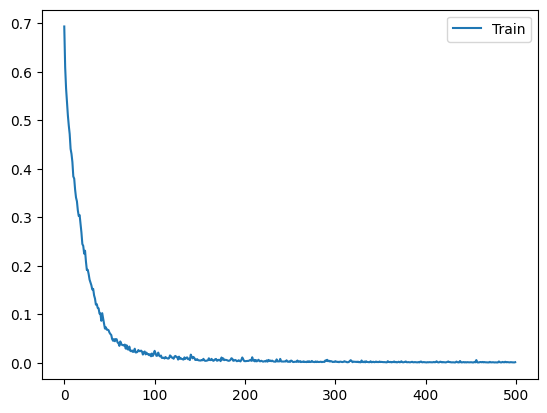

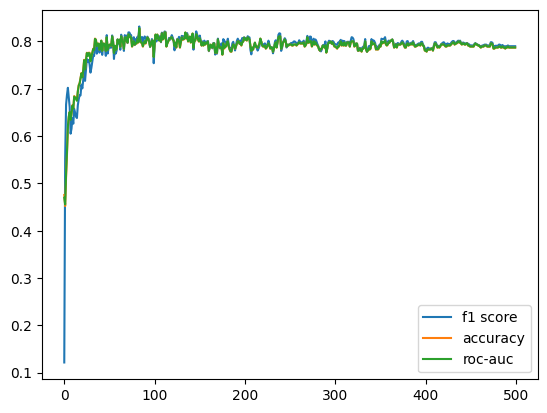

accuracy,▁▅▇▇▇█▇██████▇▇▇█▇▇█▇▇▇█▇█▇▇█▇▇▇▇▇█▇▇▇▇▇
f1_score,▂▁▅▆▇██▇█▇██▇▆▇▇█▇▆▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
roc-auc,▁▅▇▇▇█▇██████▇▇▇█▇▇█▇▇▇█▇█▇▇█▇▇▇▇▇█▇▇▇▇▇
accuracy,0.78678
f1_score,0.78992
loss,0.001
roc-auc,0.78718


 85%|█████████████████████████████████▎     | 427/500 [1:25:16<14:20, 11.79s/it]

In [ ]:
from datetime import datetime
import wandb

wandb.login()

max_accuracy = []
max_f1 = []
max_roc_auc = []

n_experiments = 3
counter = 0

for e in range(n_experiments):

    # provide new split
    X_train, X_test, y_train, y_test = prepare_data(X_full, y_full, random_state=e)

    # fixing randomness
    key = random.PRNGKey(e)
    np.random.seed(e)
    
    # Logging
    run = wandb.init(
    # Set the project where this run will be logged
    project="SPDAvgPooling",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": stiefel_optim.lr,
        "epochs": n_epochs,
        "architecture": "sphere base",
        "batch_size": batch_size
    })

    # Init model
    model = SPDNet(spd_optim=spd_optim, n_labels=n_labels, train=True)
    model_val = SPDNet(spd_optim=spd_optim, n_labels=n_labels, train=False)
    params = model.init(key, X_train[:2])
    
    # Re-init optimizers
    sphere_params, stiefel_params, euclidean_params = split_groups(params)
    # euclid
    euclidean_state = euclidean_optim.init(euclidean_params)
    euclid_clipper_state = euclid_grad_clipper.init(euclidean_params)
    # stiefel
    stiefel_optim_state = stiefel_optim.init(stiefel_params)
    stiefel_clipper_state = stiefel_grad_clipper.init(stiefel_params)
    # sphere
    sphere_optim_state = stiefel_optim.init(sphere_params)
    sphere_clipper_state = sphere_grad_clipper.init(sphere_params)
    
    
    train_loss = []
    f1_val = []
    roc_auc_val = []
    accuracy_val = []
    
    # indicies_mixed = random.permutation(key, jnp.arange(0, X_train.shape[0]))
    counter = 0
    for i in tqdm(range(n_epochs)):
        # Iterate over batches
        loss_buf = []
        
        for X, y in batch_sampler(X_train, y_train, batch_size, shuffle=True):
            
            # Perform one gradient update.
            sphere_params, stiefel_params, euclidean_params = split_groups(params)
            # loss_val, grads = loss_grad_fn(params, X, y)
            (loss_val, batch_stats), grads = loss_grad_fn(params, X, y)
            loss_buf.append(loss_val)
            
            # Split gradients to euclidean and not
            sphere_grads, stiefel_grads, euclidean_grads = split_groups(grads)
            
            # Clip gradients
            euclidean_grads, euclid_clipper_state = euclid_grad_clipper.update(euclidean_grads, euclid_clipper_state, euclidean_params)
            stiefel_grads, stiefel_clipper_state = stiefel_grad_clipper.update(stiefel_grads, stiefel_clipper_state, stiefel_params)
            sphere_grads, sphere_clipper_state = sphere_grad_clipper.update(sphere_grads, sphere_clipper_state, sphere_params)
    
            # Optax for euclidean params
            updates, euclidean_state = euclidean_optim.update(euclidean_grads, euclidean_state, params=euclidean_params)
            euclidean_params = optax.apply_updates(euclidean_params, updates)
    
            # Non Euclidean params
            stiefel_params, stiefel_optim_state = stiefel_optim.update(stiefel_params, stiefel_grads, stiefel_optim_state)
            sphere_params, sphere_optim_state = sphere_optim.update(sphere_params, sphere_grads, sphere_optim_state)
    
            # Merge
            params = unfreeze(params)
            params = merge_groups(params, sphere_params, stiefel_params, euclidean_params)
            params['batch_stats'] = batch_stats
            params = freeze(params)

            # Count iterations
            counter += 1
        
        # Save loss
        if np.isnan(np.mean(loss_buf)):
            print(f"Nan found")
            break
        else:
            train_loss.append(np.mean(loss_buf))
            
        
        # Validation
        pred_test = model_val.apply(params, X_test)
        
        roc_auc_score_val = roc_auc_score(y_test, jnp.argmax(pred_test, axis=1))
        f1_score_val = f1_score(y_test, jnp.argmax(pred_test, axis=1))
        accuracy = accuracy_score(y_test, jnp.argmax(pred_test, axis=1))
        
        f1_val.append(f1_score_val)
        accuracy_val.append(accuracy)
        roc_auc_val.append(roc_auc_score_val)

        wandb.log({"accuracy": accuracy, 
                   "f1_score": f1_score_val,
                   "roc-auc": roc_auc_score_val,
                   "loss": np.mean(loss_buf)})
        
    
    plt.plot(train_loss, label='Train')
    plt.legend()
    plt.show()
    
    plt.plot(f1_val, label='f1 score')
    plt.plot(accuracy_val, label='accuracy')
    plt.plot(roc_auc_val, label='roc-auc')
    plt.legend()
    plt.show()

    
    directory = "./results"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    date_time_format = "%Y.%m.%d-%H:%M:%S"
    date_time_str = datetime.now().strftime(date_time_format)
    prefix = directory + '/' + date_time_str + f"-seed-{e}-"

    np.save(prefix + "-loss", train_loss)
    np.save(prefix + "-f1", f1_val)
    np.save(prefix + "-roc-auc", roc_auc_val)
    np.save(prefix + "-accuracy", accuracy_val)

    max_accuracy.append(jnp.max(jnp.array(accuracy_val)))
    max_f1.append(jnp.max(jnp.array(f1_val)))
    max_roc_auc.append(jnp.max(jnp.array(roc_auc_val)))


max_accuracy = jnp.array(max_accuracy)
max_f1 = jnp.array(max_f1)
max_roc_auc = jnp.array(max_roc_auc)


In [24]:
# Final test
print(f"Accuracy: {jnp.mean(max_accuracy)} +- {jnp.std(max_accuracy)}")
print(f"F1 score: {jnp.mean(max_f1)} +- {jnp.std(max_f1)}")
print(f"ROC-AUC : {jnp.mean(max_roc_auc)} +- {jnp.std(max_roc_auc)}")

wandb.log({
    "Accuracy mean": jnp.mean(max_accuracy),
    "Accuracy std": jnp.std(max_accuracy),
    "F1 mean": jnp.mean(max_f1),
    "F1 std": jnp.std(max_f1),
    "ROC-AUC mean": jnp.mean(max_roc_auc),
    "ROC-AUC std": jnp.std(max_roc_auc)
})

Accuracy: 0.8024165034294128 +- 0.01812017150223255
F1 score: 0.8033699989318848 +- 0.021295085549354553
ROC-AUC : 0.8026483058929443 +- 0.01840372383594513


In [25]:
import pickle

with open(f'./results/SPDAvgPooling-accuracy-{jnp.mean(max_accuracy):.4f}-' + date_time_str + '.pkl', 'wb') as f:
    pickle.dump(unfreeze(params), f)

In [26]:
total_size = 0

for layer in params['params']:
    for param in params['params'][layer]:
        total_size += np.prod(params['params'][layer][param].shape)

total_size

20678